<a href="https://colab.research.google.com/github/faisalrasbihan/gru-momentum-trading/blob/main/gru9_momentum_trading_faisal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Preamble

In [54]:

import pandas as pd
import numpy as np
import datetime as dt
from numpy import ones,vstack
from numpy.linalg import lstsq
import missingno as msno
from tqdm import tqdm

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, Conv1D, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K

# Data Visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from itertools import combinations_with_replacement 
import multiprocessing

# Math & Stats
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, recall_score
from scipy import stats

# Import custom utility funciton 
import _data_processor as dp
import _visualize as viz
import _predict_model as pm
import _trade_simulation as tm

sns.set()

# 1. Import Data

In [55]:
# Read CSV - LQ45 Historical Data
df = pd.read_csv('dataset/LQ45_20210309.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.set_index('Date').sort_index().rename(columns={"Price": "Close"})
df.drop(['LQ45_Vol'],axis=1,inplace=True)

# read IDX30 data
IDX30 = pd.read_csv('dataset/IDX30_20210309.csv').rename(columns={"IDX30_Vol": "Volume"})
IDX30['Date'] = pd.to_datetime(IDX30['Date'], format='%d/%m/%Y')
IDX30 = IDX30.set_index('Date').sort_index().rename(columns={"Price": "IDX30"})

# read IHSG data
IHSG = pd.read_csv('dataset/IHSG_20210309.csv')
IHSG['Date'] = pd.to_datetime(IHSG['Date'], format='%d/%m/%Y')
IHSG = IHSG.set_index('Date').sort_index().rename(columns={"Price": "IHSG"})

IDX30.replace(0, np.nan, inplace=True)
IDX30['Volume'] = IDX30['Volume']/1000000000
IDX30.loc[IDX30.Volume > 13, 'Volume'] = np.nan

IDX30 = IDX30[['IDX30','Volume']]
IHSG = IHSG[['IHSG']]

# read EIDO data
EIDO = pd.read_csv('dataset/EIDO_20210309.csv')
EIDO['Date'] = pd.to_datetime(EIDO['Date'], format='%d/%m/%Y')
EIDO = EIDO.set_index('Date').sort_index().rename(columns={"Price": "EIDO"})

# read SPY data
SPY = pd.read_csv('dataset/SPY_20210309.csv')
SPY['Date'] = pd.to_datetime(SPY['Date'], format='%d/%m/%Y')
SPY = SPY.set_index('Date').sort_index().rename(columns={"Price": "SPY"})

SPY = SPY[['SPY']]#.resample('D').mean().shift(1).fillna(method='ffill')
EIDO = EIDO[['EIDO']]#.resample('D').mean().shift(1).fillna(method='ffill')

In [56]:
indo_jibor = pd.read_csv('dataset/indonia_jibor.csv')
indo_jibor['Date'] = pd.to_datetime(indo_jibor['Date'], format='%d/%m/%Y')
indo_jibor = indo_jibor.set_index('Date').sort_index()
indo_jibor = indo_jibor[['jibor_weekly']]
# indo_jibor.loc[indo_jibor.indonia == 0, 'indonia'] = np.nan
indo_jibor.loc[indo_jibor.jibor_weekly == 0, 'jibor_weekly'] = np.nan

# indo_jibor.interpolate(inplace=True)
indo_jibor = indo_jibor.fillna(method='bfill')

indo_jibor['jibor_diff'] = indo_jibor['jibor_weekly'].diff()

In [57]:
jci_value = pd.read_csv('dataset/JCI_value.csv')
jci_value['date'] = pd.to_datetime(jci_value['date'], format='%d/%m/%Y')
jci_value = jci_value.set_index('date').sort_index()

In [58]:
df = df.merge(SPY, how='outer', left_index=True, right_index=True).copy()
df = df.merge(EIDO, how='outer', left_index=True, right_index=True).copy()
df = df.merge(IHSG, how='left', left_index=True, right_index=True).copy()
df = df.merge(IDX30, how='left', left_index=True, right_index=True).copy()
df = df.merge(indo_jibor[['jibor_weekly']], how='left', left_index=True, right_index=True).copy()
df = df.merge(jci_value[['for_flow','dom_total','tot_buy']], how='left', left_index=True, right_index=True).copy()

# 2. Preprocess Data

In [59]:
def hampel(vals_orig, k=7, t0=3):
    #Make copy so original not edited
    vals = vals_orig.copy()
    
    #Hampel Filter
    L = 1.4826
    rolling_median = vals.rolling(window=k, center=True).median()
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    rolling_MAD = vals.rolling(window=k, center=True).apply(MAD)
    threshold = t0 * L * rolling_MAD
    difference = np.abs(vals - rolling_median)
    
    outlier_idx = difference > threshold
    vals[outlier_idx] = rolling_median[outlier_idx] 
    return outlier_idx, vals

In [60]:
# Filter volume
outlier_idx, dom_filtered = hampel(df.dom_total,k=20,t0=9)
dom_outlier = df.dom_total.copy()
dom_outlier[~outlier_idx] = np.nan
df['dom_filtered'] = dom_filtered

outlier_idx, for_filtered = hampel(df.for_flow,k=20,t0=9)
for_outlier = df.for_flow.copy()
for_outlier[~outlier_idx] = np.nan
df['for_flow_filtered'] = for_filtered

outlier_idx, total_buy_filtered = hampel(df.tot_buy,k=20,t0=9)
tot_outlier = df.tot_buy.copy()
tot_outlier[~outlier_idx] = np.nan
df['total_buy_filtered'] = total_buy_filtered

In [61]:
# Resample Date to fill missing date
df = df.resample('D').mean()

# Interpolate Close and Volume Values
df.interpolate(inplace=True)

# Remove saturday and sunday data
df['day_of_week'] = df.index.dayofweek + 1
df = df[df['day_of_week'] < 6].copy()
df.drop(columns=['day_of_week'],inplace=True)

df = df[df.index >= '2012-04-24'].copy()

In [62]:
MA_PERIOD = 5
FUTURE_DAYS = 3

df['momentum'] = dp.momentum_transformation(df, 'Close', ma_span=MA_PERIOD, normalized=False)
# df['price_volatility'] = df['1day_price_change'].rolling(10).std()
df['linear_series'] = (df.reset_index().index + 1000) / 1000
df['target'] = df['Close'].pct_change(periods=FUTURE_DAYS).shift(-(FUTURE_DAYS)) * 100

df['EIDO'] = 100*df['EIDO']/df['EIDO'][0]
df['SPY'] = 100*df['SPY']/df['SPY'][0]
df['EIDO_SPY_diff'] = df['EIDO'] - df['SPY']
df['EIDO_SPY_ma'] = df['EIDO_SPY_diff'].rolling(7).mean()

df['IDX30'] = 100*df['IDX30']/df['IDX30'][0]
df['IHSG'] = 100*df['IHSG']/df['IHSG'][0]
df['IDX30_IHSG_diff'] = df['IDX30'] - df['IHSG']
df['IDX30_IHSG_ma'] = df['IDX30_IHSG_diff'].rolling(7).mean()

df['dom_filtered'] = df['dom_filtered'] / (10**6)
df['for_flow_filtered'] = df['for_flow_filtered'] / (10**6)
df['total_buy_filtered'] = df['total_buy_filtered']/(10**6)

df['dom_val_ma'] = df['dom_filtered'].rolling(7).mean()
df['for_flow_ma'] = df['for_flow_filtered'].rolling(7).mean()
df['total_val_grad'] = df['total_buy_filtered'].rolling(3).mean() - df['total_buy_filtered'].rolling(11).mean().shift(3)

# 3. Helper function

In [63]:
def sign_accuracy(true,pred):
    true = (true*STD) + MEAN
    pred = (pred*STD) + MEAN
    return K.mean(K.equal(K.sign(true), K.sign(pred)))

In [64]:
def generate_prediction(m, X, y, dates=dt.datetime(2012, 5, 1)):
    pred = m.predict(X)[:,0]
    true = y[:,0]
    train_result = pm.bundle_predicted_actual(true,pred)
    train_result['mse'] = np.abs(train_result['true'] - train_result['pred']).rolling(7).sum()
    train_result['squared_hinge'] = 1 - train_result['true'] * train_result['pred']
    train_result.loc[train_result['squared_hinge'] < 0,'squared_hinge'] = 0
    train_result['squared_hinge'] = train_result['squared_hinge']**2
    train_result['rolling_error'] = train_result['squared_hinge'].rolling(7).mean()
    train_result['date'] = dates
    train_result['date_str'] = train_result['date'].dt.strftime('%Y-%m-%d')
    train_result['date_to_val'] = train_result['date'].map(pd.Series(data=np.arange(len(train_result)), 
                                                                     index=train_result['date'].values).to_dict())
    return pred,true,train_result

In [65]:
def create_model(neurons,output_timesteps,shape1,shape2,loss_function):
    model = tf.keras.Sequential()
    model.add(GRU(neurons, activation='linear', input_shape=(shape1,shape2)))
    model.add(Dense(output_timesteps, activation='tanh'))
    model.compile(optimizer='adam', loss=loss_function, metrics=[sign_accuracy])
    return model

In [66]:
def multi_gru_model(neurons,output_timesteps,shape1,shape2,loss_function):
    model = tf.keras.Sequential()
    model.add(GRU(50, return_sequences=True, activation='linear', input_shape=(shape1,shape2)))
    model.add(Dropout(0.2))
    model.add(GRU(50, activation='linear'))
    model.add(Dropout(0.2))
    model.add(Dense(output_timesteps, activation='tanh'))
    model.compile(optimizer='adam', loss=loss_function, metrics=[sign_accuracy])
    return model

In [67]:
def multi_layer_model(gru_neurons,hidden_neurons,output_timesteps,shape1,shape2,loss_function):
    model = tf.keras.Sequential()
    model.add(GRU(gru_neurons, activation='linear', input_shape=(shape1,shape2)))
    model.add(Dense(hidden_neurons, activation='tanh'))
    model.add(Dense(1, activation='tanh'))
    model.compile(optimizer='adam', loss=loss_function, metrics=[sign_accuracy])
    return model

In [68]:
MEAN_pre_filtered = 0.06968521192214656
STD_pre_filtered = 2.3073312870270306

def target_inverse_transform(x, mean=MEAN_pre_filtered, std=STD_pre_filtered):
    return (x*STD) + MEAN

def target_transform(x, mean=MEAN_pre_filtered, std=STD_pre_filtered):
    return (x - MEAN)/STD

In [69]:
def train_test_date_split(df_orig, range1='2020-01-01', range2='2019-01-01', range3='2020-01-01', range4='2021-02-01'):
    df = df_orig.copy()
    df_train = df[(df.index < range1)].copy()
    df_test = df[(df.index >= range2) & (df.index < range3)].copy()
    df_test2 = df[(df.index >= range3) & (df.index < range4)].copy()
    return df_train, df_test, df_test2

In [70]:
def plot_all(df, cols):
    fig, ax = plt.subplots(len(cols), 2, figsize=(18,len(cols)*4), gridspec_kw={'width_ratios': [1, 3]})
    colors = sns.color_palette()
    colors += colors
    for i, col in enumerate(cols):
        sns.histplot(df[col], ax=ax[i,0], color=colors[i])
        ax[i,1].plot(df.index, df[col], color=colors[i])
        ax[i,1].set_title(col)
        ax[i,0].grid()
#         ax[i,0].set_ylim(0,ylim)
    plt.tight_layout()

In [71]:
slow_and_fast = [(6,6),(7,5),(8,4),(9,3),(9,7),(10,6),(8,6),(9,5),(10,4),(11,3)]
combi = list(combinations_with_replacement(slow_and_fast,3))
highacc_combi = list(combi[i] for i in [4, 14, 21, 28])
highacc_combi

[((6, 6), (6, 6), (9, 7)),
 ((6, 6), (7, 5), (10, 6)),
 ((6, 6), (8, 4), (9, 7)),
 ((6, 6), (9, 3), (9, 7))]

# 4. Feature Engineering

In [72]:
# Remove outliers
df = df[(df['target'] < 3*STD_pre_filtered) & (df['target'] > -3*STD_pre_filtered)]

# Determine mean and standard deviation
MEAN = np.mean(df['target'].values)
STD = np.std(df['target'].values)
print('Mean: ', MEAN)
print('STD: ', STD)

# Plot result
fig = px.histogram(df, x="target",
                   marginal="box", # or violin, rug
                   hover_data=df.columns)
fig.show()


Mean:  0.10263738808988873
STD:  1.907956821190298


# 5. Train Model

In [75]:
target_variables = 'target'
input_variables = ['momentum','IDX30_IHSG_grad','EIDO_SPY_grad','total_val_grad','dom_val_ma','for_flow_ma']
neurons = 90
multi_neurons = (20,5)
loss = 'squared_hinge'
input_timesteps = 20
output_timesteps = 1
epochs = 80
validation_split = 0.2
span = 4
d = highacc_combi[1]

In [77]:
# Final Variables
df2 = df.copy()
df2['jibor_ma'] = df2['jibor_weekly'].rolling(3).mean()
df2['jibor_diff'] = df2.jibor_weekly.diff()
df2['momentum'] = dp.momentum_transformation(df2, 'Close', ma_span=span, normalized=False)
df2['EIDO_SPY_grad'] = df2['EIDO_SPY_diff'].rolling(d[0][1]).mean() - df2['EIDO_SPY_diff'].rolling(d[0][0]).mean().shift(d[0][1])
df2['IDX30_IHSG_grad'] = df2['IDX30_IHSG_diff'].rolling(d[1][1]).mean() - df2['IDX30_IHSG_diff'].rolling(d[1][0]).mean().shift(d[1][1])
df2['Volume_grad'] = df2['Volume'].rolling(d[2][1]).mean() - df2['Volume'].rolling(d[2][0]).mean().shift(d[2][1])

df2['target'] = df2['target'].apply(target_transform, mean=MEAN, std=STD) # Standardize target with predetermined constants

# Train test split
df2 = df2.dropna()

# Final Sanity Check
df2[(df2.index > '2020-11-09')][input_variables + [target_variables]]

,momentum,IDX30_IHSG_grad,EIDO_SPY_grad,total_val_grad,dom_val_ma,for_flow_ma,target
Date,,,,,,,
2020-11-10,25.0850,1.597008,-2.882731,3.667802,14.928623,0.458449,0.142151
2020-11-11,25.1700,2.720250,-6.302816,5.519832,16.853821,0.817652,-0.445685
2020-11-12,3.8850,3.346266,-7.824455,5.160973,17.506280,0.894226,0.861186
2020-11-13,-2.2675,3.563341,-7.583980,2.188416,17.629074,0.859133,1.061292
2020-11-16,1.6050,3.637999,-6.788395,-0.638807,17.588039,0.704874,0.767095
...,...,...,...,...,...,...,...
2021-02-25,-0.8875,-0.325635,1.484702,1.546248,21.119597,0.167836,0.778161
2021-02-26,-7.0550,-0.355907,2.701141,4.654130,21.743407,0.168898,1.248256
2021-03-01,13.7875,0.008931,2.905305,3.835739,21.814481,0.173242,-1.096382


In [78]:
df_train = df2[(df2.index < '2019-01-01')].copy()
df_test = df2[(df2.index >= '2019-01-01') & (df2.index <= '2020-02-01')].copy()
df_test2 = df2[(df2.index >= '2020-01-01') & (df2.index <= '2021-02-01')].copy()
df_test3 = df2[(df2.index >= '2020-01-01') & (df2.index <= '2021-02-01')].copy()

# Unroll data
dates = df_train[(input_timesteps+output_timesteps-1):].index
# train_mask = ((df_train.index < '2020-02-01') | (df_train.index > '2020-06-01'))
# df_train = df_train[train_mask]
# dates = dates[(dates < '2020-02-01') | (dates > '2020-06-01')]
X_train, y_train = dp.generate_batch(df_train, input_timesteps, output_timesteps, input_variables, target_variables)
X_test, y_test = dp.generate_batch(df_test, input_timesteps, output_timesteps, input_variables, target_variables)
X_test2, y_test2 = dp.generate_batch(df_test2, input_timesteps, output_timesteps,  input_variables, target_variables)
X_test3, y_test3 = dp.generate_batch(df_test3, input_timesteps, output_timesteps,  input_variables, target_variables)

# Build LSTM Model using Tensorflow
model = create_model(neurons, output_timesteps, X_train.shape[1], X_train.shape[2], loss)
# model = multi_layer_model(multi_neurons[0],multi_neurons[1],output_timesteps,X_train.shape[1], X_train.shape[2],loss)
# model = multi_layer_model(multi_neurons[0],multi_neurons[1],output_timesteps,X_train.shape[1], X_train.shape[2],loss)

model_name = 'gru7_oneoff_n{neurons}_{feature_count}var_span{span}_X1.hdf5'.format(
                                                                                neurons=neurons,
                                                                                span=span,
                                                                                feature_count=len(input_variables))
model_path = 'temp_model/{}'.format(model_name)
mcp_save = ModelCheckpoint(model_path, save_best_only=True, monitor='val_sign_accuracy', mode='max',verbose=1)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=len(X_train),
    validation_split=validation_split,
    verbose = 2, 
    shuffle=True,
    callbacks=[mcp_save]
)

new_model = tf.keras.models.load_model(model_path, compile=False)

Epoch 1/80
1/1 - 2s - loss: 1.4748 - sign_accuracy: 0.4567 - val_loss: 1.3871 - val_sign_accuracy: 0.4112

Epoch 00001: val_sign_accuracy improved from -inf to 0.41124, saving model to temp_model/gru7_oneoff_n90_6var_span4_X1.hdf5
Epoch 2/80
1/1 - 0s - loss: 1.3317 - sign_accuracy: 0.4530 - val_loss: 1.2079 - val_sign_accuracy: 0.4586

Epoch 00002: val_sign_accuracy improved from 0.41124 to 0.45858, saving model to temp_model/gru7_oneoff_n90_6var_span4_X1.hdf5
Epoch 3/80
1/1 - 0s - loss: 1.1576 - sign_accuracy: 0.4693 - val_loss: 1.1521 - val_sign_accuracy: 0.5059

Epoch 00003: val_sign_accuracy improved from 0.45858 to 0.50592, saving model to temp_model/gru7_oneoff_n90_6var_span4_X1.hdf5
Epoch 4/80
1/1 - 0s - loss: 1.0566 - sign_accuracy: 0.5352 - val_loss: 1.1913 - val_sign_accuracy: 0.5266

Epoch 00004: val_sign_accuracy improved from 0.50592 to 0.52663, saving model to temp_model/gru7_oneoff_n90_6var_span4_X1.hdf5
Epoch 5/80
1/1 - 0s - loss: 1.0717 - sign_accuracy: 0.5455 - val_lo

In [79]:
# plot training history
hist = pd.DataFrame.from_dict(history.history)
fig = go.Figure()

fig.add_trace(go.Scatter(y=hist['loss'],line=dict(color='blue'),name='train_loss'))
fig.add_trace(go.Scatter(y=hist['val_loss'],line=dict(color='firebrick'),name='val_loss'))

fig.update_layout(
    title="Train and Validation Loss per epoch",
    xaxis_title="Epoch",
    yaxis_title="Loss")
fig.show()

In [80]:
# plot training history
hist = pd.DataFrame.from_dict(history.history)
fig = go.Figure()

fig.add_trace(go.Scatter(y=hist['sign_accuracy'],line=dict(color='blue'),name='train'))
fig.add_trace(go.Scatter(y=hist['val_sign_accuracy'],line=dict(color='firebrick'),name='val'))

fig.update_layout(
    title="Train and Validation Accuracy per epoch",
    xaxis_title="Epoch",
    yaxis_title="Accuracy")
fig.show()

# 6. Evaluate Model

In [81]:
# Generate result from model
_,_,train_result = generate_prediction(new_model,X_train,y_train,dates)
_,_,test_result = generate_prediction(new_model,X_test,y_test,df_test.index[(input_timesteps+output_timesteps-1):])
_,_,test_result2 = generate_prediction(new_model,X_test2,y_test2,df_test2.index[(input_timesteps+output_timesteps-1):])
_,_,test_result3 = generate_prediction(new_model,X_test3,y_test3,df_test3.index[(input_timesteps+output_timesteps-1):])

## 6.1 Train Result Evaluation

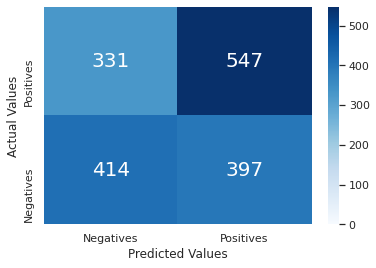

In [82]:
conf_matrix = confusion_matrix(train_result['true_bin'], train_result['pred_bin'])[::-1]
viz.display_confusion_matrix(conf_matrix, reverse_ylabel=True)

In [83]:
print(classification_report(train_result['true_bin'],train_result['pred_bin'], target_names=['Negatives','Positives']))

              precision    recall  f1-score   support

   Negatives       0.56      0.51      0.53       811
   Positives       0.58      0.62      0.60       878

    accuracy                           0.57      1689
   macro avg       0.57      0.57      0.57      1689
weighted avg       0.57      0.57      0.57      1689



## 6.2 Test Result Evaluation

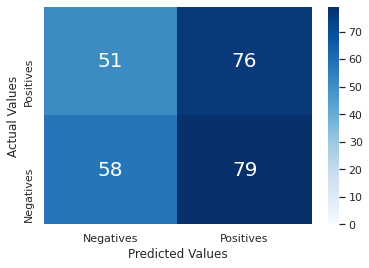

In [84]:
conf_matrix2 = confusion_matrix(test_result['true_bin'],test_result['pred_bin'])[::-1]
viz.display_confusion_matrix(conf_matrix2, reverse_ylabel=True)

In [85]:
print(classification_report(test_result['pred_bin'], test_result['true_bin'], target_names=['Negatives','Positives']))

              precision    recall  f1-score   support

   Negatives       0.42      0.53      0.47       109
   Positives       0.60      0.49      0.54       155

    accuracy                           0.51       264
   macro avg       0.51      0.51      0.51       264
weighted avg       0.53      0.51      0.51       264



#  7. Run Trading Simulation

In [86]:
def plot_returns(df):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=[24, 12])
    
    # Add patch as legend
    red_patch = mpl.patches.Patch(color='#bb3f3f', label='Sell')
    green_patch = mpl.patches.Patch(color='#008000', label='Buy')
    
    # Closing price chart
    close = 100*df['Close']/df['Close'][0]
    sns.lineplot(data=close, ax=ax[0])
    ax[0].set_ylabel('Closing Price')
    buys = df.loc[df.position == 'Buy'] # mark buy transactions
    sells = df.loc[df.position == 'Sell'] # mark sell transactions
    
    # Add dashed line on last closing price
    last_closing_price = close[-1]
    ax[0].axhline(last_closing_price, ls='--',linewidth=1, color='m')
    ax[0].plot(buys.index, close.loc[buys.index], '.', markersize=8, color='g', label='buy')
    ax[0].plot(sells.index, close.loc[sells.index], '.', markersize=8, color='r', label='sell')
    ax[0].annotate((last_closing_price).round(2),xy=(1,last_closing_price),xycoords=('axes fraction','data'),ha='left',va='center',color='black')
    ax[0].grid(True)
    ax[0].legend(handles=[red_patch, green_patch])

    # Price change chart
    sns.lineplot(data=df[['target','pred']], ax=ax[1])
    ax[1].set_ylabel('target'.format(3))
    ax[1].grid(True)

    # Portfolio value
    port_value = df['value'] / df['value'][0]
    sns.lineplot(data=port_value, ax=ax[2])
    ax[2].set_ylabel('Portfolio Value')
    last_value = port_value[-1]
    ax[2].axhline(last_value, ls='--',linewidth=1, color='m')
    ax[2].annotate((last_value).round(2),xy=(1,last_value),xycoords=('axes fraction','data'),ha='left',va='center',color='black')
    ax[2].grid(True)

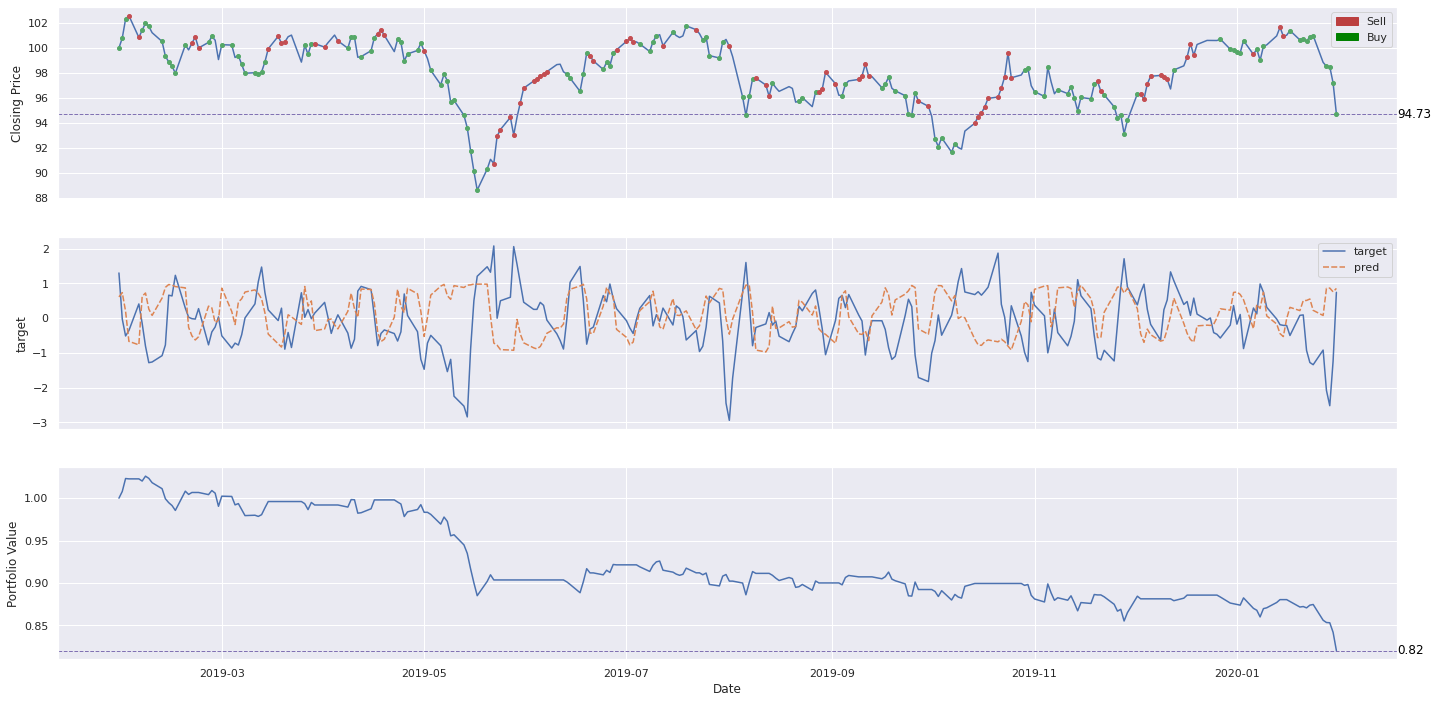

In [87]:
test_date = df_test[(input_timesteps+output_timesteps-1):].index
res = pd.DataFrame(test_date)
res['pred'] = test_result['pred']
res = res.set_index(['Date'])
res = df_test.merge(res, how='inner', left_index=True, right_index=True).copy()

test_returns = tm.simulate_position(res,0.15,-0.3,buy_fee=0.0025,sell_fee=0.003)#dp.generate_returns(res)
plot_returns(test_returns)

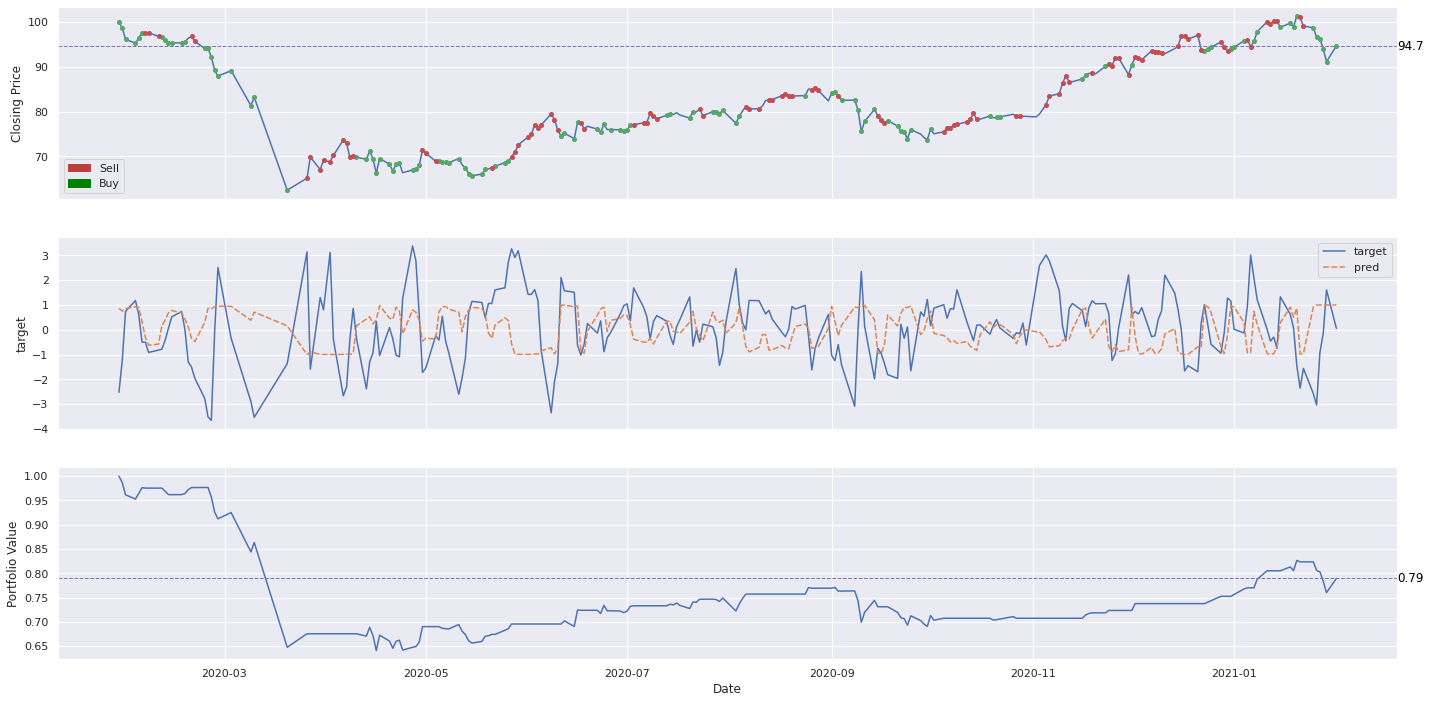

In [88]:
test_date2 = df_test2[(input_timesteps+output_timesteps-1):].index
res = pd.DataFrame(test_date2)
res['pred'] = test_result2['pred']
res = res.set_index(['Date'])

res = df_test2.merge(res, how='inner', left_index=True, right_index=True).copy()

test_returns2 = tm.simulate_position(res,0.15,-0.2)#dp.generate_returns(res)
plot_returns(test_returns2)